In [ ]:
!pip install pennylane > h

**Exercise 1**

Given the following dataset:

```python
xs = np.array([-1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5, 0.7,  0.9,  1.1,  1.3,  1.5])
ys = np.array([2.33, 2.98, 2.81, 2.17, 1.41, 0.74, 0.27, 0.03, 0.03, 0.27, 0.74, 1.41, 2.17, 2.81, 2.98, 2.33])
```

Generate a quantum model `circuit(x, params)` which output is able to predict the value of `y` .



**Solution 1**

First we can plot the dataset to visualise the distribution.

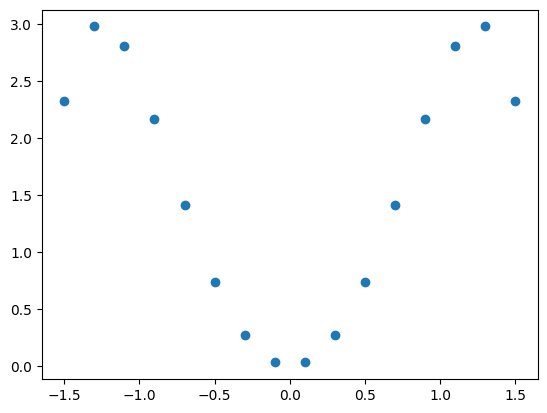

In [ ]:
from pennylane import numpy as np
import matplotlib.pyplot as plt

xs = np.array([-1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5, 0.7,  0.9,  1.1,  1.3,  1.5])
ys = np.array([2.33, 2.98, 2.81, 2.17, 1.41, 0.74, 0.27, 0.03, 0.03, 0.27, 0.74, 1.41, 2.17, 2.81, 2.98, 2.33])

plt.scatter(xs, ys)

Now, we'll do a standard round of training, defining a loss function and applying a gradient descent.


In [ ]:
import pennylane as qml

dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def circuit(theta0, x):
    qml.RY(theta0 * x, wires = 0)
    return qml.expval(qml.PauliZ(wires = 0))

def q_model(theta0, theta1, theta2, x):
    return circuit(theta0, x) * theta1 + theta2

def q_error(theta0, theta1, theta2):
    er = 0
    for x, y in zip(xs, ys):
        er += (q_model(theta0, theta1, theta2, x) - y) ** 2
    return np.sqrt(er) / len(xs)


theta0, theta1, theta2 = np.random.rand(3) * np.pi
gradient_fn_theta = qml.grad(q_error, argnum = [0,1,2])

lr = 0.9

for epoch in range(101):
    gradiente = gradient_fn_theta(theta0, theta1, theta2)
    theta0 = theta0 - lr*gradiente[0]
    theta1 = theta1 - lr*gradiente[1]
    theta2 = theta2 - lr*gradiente[2]
    if epoch % 5 == 0:
        print("epoch", epoch, "loss", q_error(theta0, theta1, theta2))


epoch 0 loss 0.3806271050874542
epoch 5 loss 0.2807816521740965
epoch 10 loss 0.22182986311826491
epoch 15 loss 0.1364806184909633
epoch 20 loss 0.036245700894820695
epoch 25 loss 0.03554440293106915
epoch 30 loss 0.03554400604600265
epoch 35 loss 0.035543922214142806
epoch 40 loss 0.03554390066594461
epoch 45 loss 0.035543895127393185
epoch 50 loss 0.03554389370365355
epoch 55 loss 0.035543893337685345
epoch 60 loss 0.03554389324361172
epoch 65 loss 0.035543893219430016
epoch 70 loss 0.03554389321321406
epoch 75 loss 0.03554389321161623
epoch 80 loss 0.03554389321120549
epoch 85 loss 0.03554389321109994
epoch 90 loss 0.03554389321107278
epoch 95 loss 0.0355438932110658
epoch 100 loss 0.035543893211064055


Once the model is trained, we can plot the dataset again to visualise the predictions.

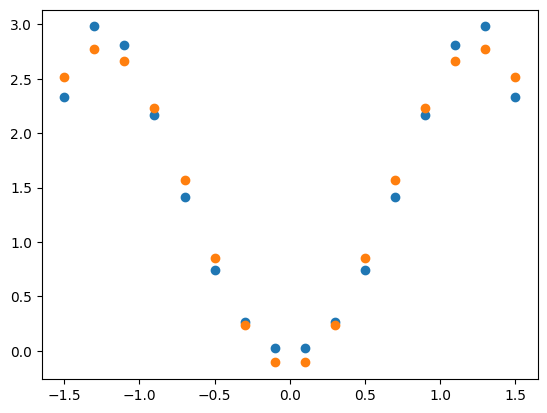

In [ ]:
preds = [q_model(theta0, theta1, theta2, x) for x in xs]

plt.scatter(xs, ys)
plt.scatter(xs, preds)


**Exercise 2**

Generalise the previous circuit to more qubits to solve a classification task for Iris dataset. Use the following script as an aid to generate the dataset.


```python
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()

# Accesing to the features (data) and the labels (target) of the dataset
X = iris.data  # features
y = iris.target  # labels
```
Note: It is good practice to normalise the data between [0,2π] before introducing it into a quantum computer.|

# Solution

Epoch   0: Cost = 1.2092 | Train Accuracy = 0.42
Epoch  10: Cost = 1.0957 | Train Accuracy = 0.42
Epoch  20: Cost = 1.0229 | Train Accuracy = 0.44
Epoch  30: Cost = 0.9744 | Train Accuracy = 0.57
Epoch  40: Cost = 0.9407 | Train Accuracy = 0.65
Epoch  50: Cost = 0.9160 | Train Accuracy = 0.68
Epoch  60: Cost = 0.8972 | Train Accuracy = 0.71
Epoch  70: Cost = 0.8822 | Train Accuracy = 0.72
Epoch  80: Cost = 0.8697 | Train Accuracy = 0.72
Epoch  90: Cost = 0.8590 | Train Accuracy = 0.72

Test Accuracy: 90.00%


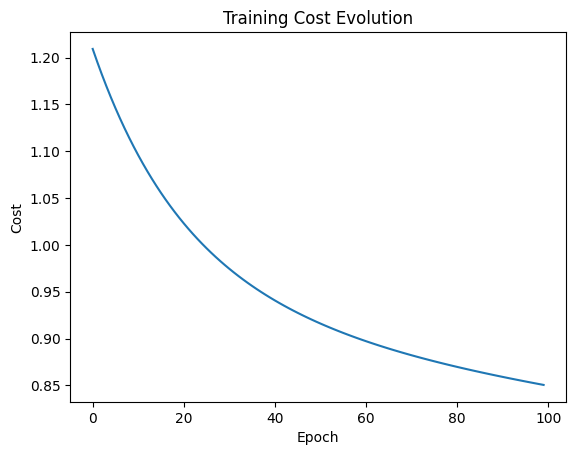

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Load and normalize the Iris dataset
iris = load_iris()
X = iris.data                # shape (150, 4), four features per sample
y = iris.target              # labels: 0, 1, 2 (three classes)
n_features = X.shape[1]      # 4 features
n_classes = len(np.unique(y))  # 3 classes

# Normalize the features to [0, 2π]
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X_scaled = scaler.fit_transform(X)

# Split into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 2. Define a quantum circuit that will encode data and has variational layers
# We use one qubit per feature (4 qubits total)
n_qubits = n_features

# Setup the quantum device with the required number of wires
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def circuit(q_params, x):
    """
    Encodes a 4-dimensional input "x" (already scaled to [0,2π])
    into the quantum state by applying a RY rotation to each qubit.
    Then, two layers of variational rotations and an entangling layer are applied.
    Finally, we return the expectation values of PauliZ on each qubit.
    """
    # --- Data encoding ---
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)

    # --- Variational layer 1 ---
    for i in range(n_qubits):
        qml.RY(q_params[0, i], wires=i)
        qml.RZ(q_params[1, i], wires=i)

    # --- Entangling layer ---
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # --- Variational layer 2 ---
    for i in range(n_qubits):
        qml.RY(q_params[2, i], wires=i)
        qml.RZ(q_params[3, i], wires=i)

    # Measure all qubits (each expectation lies in [-1, 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# 3. Build the hybrid quantum–classical model for classification

def softmax(logits):
    """Compute softmax probabilities from logits."""
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits)

def q_model(q_params, W, b, x):
    """
    First run the quantum circuit to obtain 4 expectation values.
    Then apply a classical linear layer (matrix multiplication plus bias)
    to yield 3 logits (one per Iris class).
    Finally, convert the logits into probabilities using softmax.
    """
    # Run the quantum circuit (data encoding + variational ansatz).
    q_out = circuit(q_params, x)  # q_out is a list of length 4
    q_out = np.array(q_out)

    # Map quantum outputs to class logits via a linear transformation.
    logits = np.dot(W, q_out) + b  # shape: (n_classes,)
    probs = softmax(logits)
    return probs

def cost(q_params, W, b, X, Y):
    """
    Define the average cross-entropy loss over the dataset.
    For each data point we have a probability distribution from the circuit,
    so the loss for the correct class is -log(probability for that class).
    """
    loss = 0
    for x, target in zip(X, Y):
        probs = q_model(q_params, W, b, x)
        # Add a small epsilon for numerical stability.
        loss += -np.log(probs[target] + 1e-6)
    return loss / len(X)

def predict(q_params, W, b, x):
    """Predict the class label for a given data point."""
    probs = q_model(q_params, W, b, x)
    return np.argmax(probs)

def accuracy(q_params, W, b, X, Y):
    """Compute classification accuracy on a dataset."""
    correct = 0
    for x, target in zip(X, Y):
        if predict(q_params, W, b, x) == target:
            correct += 1
    return correct / len(X)

# 4. Initialize the parameters

# Quantum circuit parameters: Here we have 4 layers (2 variational layers, each with two parameters per qubit)
q_params = np.random.uniform(0, np.pi, size=(4, n_qubits))

# Classical linear layer parameters: map the 4 quantum outputs to 3 logits.
W = np.random.normal(0, 1, size=(n_classes, n_qubits))
b = np.random.normal(0, 1, size=(n_classes,))

# 5. Set up a gradient function for all parameters (quantum + classical)
grad_fn = qml.grad(cost, argnum=[0, 1, 2])

# 6. Train the hybrid classifier
lr = 0.1
epochs = 100
cost_history = []

for epoch in range(epochs):
    # Compute gradients for quantum parameters, weight matrix W, and bias b.
    grads = grad_fn(q_params, W, b, X_train, y_train)

    # Update parameters using gradient descent.
    q_params = q_params - lr * grads[0]
    W = W - lr * grads[1]
    b = b - lr * grads[2]

    current_cost = cost(q_params, W, b, X_train, y_train)
    cost_history.append(current_cost)

    if epoch % 10 == 0:
        train_acc = accuracy(q_params, W, b, X_train, y_train)
        print(f"Epoch {epoch:3d}: Cost = {current_cost:.4f} | Train Accuracy = {train_acc:.2f}")

# 7. Evaluate the trained model on the test set
test_acc = accuracy(q_params, W, b, X_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# 8. Plot the cost evolution during training
plt.plot(cost_history)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Training Cost Evolution")
plt.show()
